# Manual Approach

In [0]:
from google.colab import drive
drive.mount('/content/drive')
from collections import defaultdict
import math
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from __future__ import print_function

import pandas as pd
pd.__version__

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'1.0.3'

In [0]:
"""This segment contains methods for reading the file in from the path as 
well as splitting training data between senses"""

def read_file(path):
  with open(path) as fin:
    tweets = []
    sentiments = []
    ps = nltk.stem.PorterStemmer()
    sw = stopwords.words("english")

    for line in fin:
      arr = line.lower().strip().split()
      for i in range(1, len(arr)):
        arr[i] = ps.stem(arr[i])
      tweets.append(arr[1:])
      sentiments.append(arr[0])
    
    return tweets, sentiments

def split_senses(tweets, sentiments):
  positives = []
  neutrals = []
  negatives = []

  for i, tweet in enumerate(tweets):
    if sentiments[i] == "positive":
      positives.append(tweet)
    elif sentiments[i] == "negative":
      negatives.append(tweet)
    else:
      neutrals.append(tweet)
  return positives, neutrals, negatives

In [0]:
"""This next section of code has to do with translating the text data of the 
tweets into numerical TF-IDF values.

The TF-IDF values can then be averaged into centroid values."""

def calculate_df(tweets):
  doc_freqs = defaultdict(int)
  for tweet in tweets:
    for word in tweet:
      doc_freqs[word] += 1
  return doc_freqs

def calculate_tf(tweets):
  all_tfs = []
  for tweet in tweets:
    cur_tf = defaultdict(float)
    term_count = 0
    for word in tweet:
      cur_tf[word] += 1.0
      term_count += 1
    
    for key in cur_tf.keys():
      cur_tf[key] = cur_tf[key] / term_count
    
    all_tfs.append(cur_tf)
  
  return all_tfs

def calculate_tfidf(doc_freqs, term_freqs):
  tfidfs = []
  for tweet in term_freqs:
    cur_rows_tfidf = defaultdict(float)
    for word in tweet.keys():
      if word in doc_freqs:
        idf = math.log10(len(term_freqs) / (doc_freqs[word] + 1))
      else:
        idf = math.log10(len(term_freqs) / (1))
      cur_tfidf = tweet[word] * idf
      cur_rows_tfidf[word] = cur_tfidf
    tfidfs.append(cur_rows_tfidf)
  return tfidfs

def calculate_centroid(tfidfs, doc_freqs):
  centroid = defaultdict(float)
  for doc in tfidfs:
    for word in doc:
      centroid[word] += doc[word]
    
  for word in centroid.keys():
    if word in doc_freqs:
      centroid[word] = centroid[word] / doc_freqs[word]
    else:
      centroid[word] = centroid[word] / 1
  
  return centroid


In [0]:
"""
This section has methods to compare test data and centroids
"""

def cos_similarity(sentiment_centroid, test_document):
  sim = 0
  numerator = 0
  centroid_norm = 0
  test_doc_norm = 0
  
  for term in test_document:
    if term in sentiment_centroid:
      numerator += (sentiment_centroid[term] * test_document[term])
    test_doc_norm += (test_document[term] ** 2)
  
  for term in sentiment_centroid:
    centroid_norm += (sentiment_centroid[term] ** 2)
  
  test_doc_norm = math.sqrt(float(test_doc_norm))
  centroid_norm = math.sqrt(float(centroid_norm))

  sim = numerator / (test_doc_norm * centroid_norm)

  return sim

def compare_similarities(centroids, test_tweet):
  pos_sim = cos_similarity(centroids['positive'], test_tweet)
  neut_sim = cos_similarity(centroids['neutral'], test_tweet)
  neg_sim = cos_similarity(centroids['negative'], test_tweet)

  highest_sim = max(pos_sim, neut_sim, neg_sim)

  if pos_sim == highest_sim:
    return "positive"
  elif neut_sim == highest_sim:
    return "neutral"
  else:
    return "negative"
  

In [0]:
def test_data(test_path, all_sentiment_centroids):
  test_tweets, actual_sentiments = read_file(test_path)

  individual_tweet_tfidfs = []
  for tweet in test_tweets:
    doc_freqs = calculate_df([tweet])
    term_freqs = calculate_tf([tweet])
    tfidfs = calculate_tfidf(doc_freqs, term_freqs)
    # centroid = calculate_centroid(tfidfs, doc_freqs)
    individual_tweet_tfidfs.append(tfidfs[0])

  experimental_sentiments = []
  for tweet_tfidf in individual_tweet_tfidfs:
    # print(tweet_tfidf)
    result = compare_similarities(all_sentiment_centroids, tweet_tfidf)
    experimental_sentiments.append(result)

  accuracy = evaluate_accuracy(experimental_sentiments, actual_sentiments)
  return accuracy

def evaluate_accuracy(experimental_sentiments, actual_sentiments):
  num_correct = 0
  for i in range(len(experimental_sentiments)):
    if experimental_sentiments[i] == actual_sentiments[i]:
      num_correct += 1
  
  percent_correct = float(num_correct) / float(len(experimental_sentiments))
  
  return percent_correct

In [0]:
def train_data(training_path):
  #read data in from the txt file
  train_tweets, train_sentiments = read_file(training_path)
  #split data up from huge tweet list to lists associated with that sense
  positives, neutrals, negatives = split_senses(train_tweets, train_sentiments)
  
  #compute doc frequencies of each sense
  pos_dfs = calculate_df(positives)
  neut_dfs = calculate_df(neutrals)
  neg_dfs = calculate_df(negatives)

  #compute term frequency of each sense
  pos_tfs = calculate_tf(positives)
  neut_tfs = calculate_tf(neutrals)
  neg_tfs = calculate_tf(negatives)

  # print(str(len(pos_dfs)) + " should equal " + str(len(pos_tfs)))
  
  #compute tfidf of each sense
  pos_tfidfs = calculate_tfidf(pos_dfs, pos_tfs)
  neut_tfidfs = calculate_tfidf(neut_dfs, neut_tfs)
  neg_tfidfs = calculate_tfidf(neg_dfs, neut_tfs)

  #compute centroids of each sense
  pos_centroid = calculate_centroid(pos_tfidfs, pos_dfs)
  neut_centroid = calculate_centroid(neut_tfidfs, neut_dfs)
  neg_centroid = calculate_centroid(neg_tfidfs, neg_dfs)

  all_centroids = {
      "positive": pos_centroid,
      "neutral": neut_centroid,
      "negative": neg_centroid
  }

  return all_centroids

In [0]:
def main():
  data_train = "/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/semeval_train.txt"
  test2013 = '/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/Twitter2013_raw.txt'
  test2014 = '/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/Twitter2014_raw.txt'
  test2015 = '/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/Twitter2015_raw.txt'
  test2016 = '/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/Twitter2016_raw.txt'

  sentiment_centroids = train_data(data_train)
  test_results2013 = test_data(test2013, sentiment_centroids)
  test_results2014 = test_data(test2014, sentiment_centroids)
  test_results2015 = test_data(test2015, sentiment_centroids)
  test_results2016 = test_data(test2016, sentiment_centroids)

  print("2013 accuracy: " + str(test_results2013))
  print("2014 accuracy: " + str(test_results2014))
  print("2015 accuracy: " + str(test_results2015))
  print("2016 accuracy: " + str(test_results2016))
  # for i in range(len(tweets)):
  #   print("Sentiment: {}    tweet: {}".format(sentiments[i], tweets[i]))
  

if __name__ == '__main__':
    main()

2013 accuracy: 0.4176285414480588
2014 accuracy: 0.4006479481641469
2015 accuracy: 0.42109669317706155
2016 accuracy: 0.4486937133439969


# ML

In [0]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import ExtraTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


with open("/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/semeval_train.txt") as fin:
    tweets = []
    senses = []
    sentiments = []
    for line in fin:
        arr = line.lower().strip().split()
        tweets.append(line)
        sentiments.append(arr[0])
    for i, tweet in enumerate(tweets):
        if sentiments[i] == "positive":
            senses.append('positive')
        elif sentiments[i] == "negative":
            senses.append('negative')
        else:
            senses.append('neutral')

def features():
    vector = TfidfVectorizer()
    vector.fit(tweets)
    feats = (vector.transform(tweets))
    trainX, testX, trainY, testY = train_test_split(feats, senses, train_size = 0.5, test_size = 0.5)
    return trainX, testX, trainY, testY

def classifier(trainX, testX, trainY, testY):
    model = ExtraTreeClassifier()
    model = model.fit(trainX, trainY)
    prediction = model.predict(testX)
    return prediction

def main():
    trainX, testX, trainY, testY = features()
    prediction = classifier(trainX, testX, trainY, testY)
    accuracy = accuracy_score(testY, prediction)
    print(accuracy)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0.7900976290097629


In [0]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer


class SentimentClassifier1:
    def train(self, trainX, trainY):
        self.clf = DummyClassifier(strategy='most_frequent')
        self.clf.fit(trainX, trainY)

    def classify(self, testX):
        # same as return ['EOS' for i in range(len(testX))]
        return self.clf.predict(testX)

class SentimentClassifier2:
    def train(self, trainX, trainY):
        self.clf = RandomForestClassifier()
        self.clf.fit(trainX, trainY)

    def classify(self, testX):
        return self.clf.predict(testX)

class SentimentClassifier3:
    def train(self, trainX, trainY):
        self.clf = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3)
        self.clf.fit(trainX, trainY)

    def classify(self, testX):
        return self.clf.predict(testX)

def load_data(file):
    with open(file) as fin:
        X = []
        y = []
        for line in fin:
            #print(line)
            arr = line.strip().split('\t', 1)
            X.append(arr[1])
            y.append(arr[0])
        return X, y

def get_sentiments(file):
    sentiments = {}
    arr = []
    with open(file) as fin:
         for line in fin:
             arr.append(line.split())
    for line in arr:
        word = line[2][6:]
        senti = line[5][14:]
        sentiments[word] = senti

    return sentiments

def addFeatures(xFile):
    newFeatures = []
    dataset = get_sentiments("/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/sentiments.txt")
    for i in range(len(xFile)):
        newFeatures.append([0,0,0])
        tweet = xFile[i]
        for word in tweet:
            if word.find('!') != -1:
                newFeatures[i][0] = 1
            if ':)' in word or ';)' in word:
                newFeatures[i][1] = 1
            elif ':(' in word or ';(' in word:
                newFeatures[i][1] = -1
            if word in dataset:
                if dataset[word] == 'positive':
                    newFeatures[i][2] = newFeatures[i][2] + 1
                else:
                    newFeatures[i][2] = newFeatures[i][2] - 1

    return newFeatures

def evaluate(outputs, golds):
    correct = 0
    for h, y in zip(outputs, golds):
        if h == y:
            correct += 1
    print(f'{correct} / {len(golds)}  {correct / len(golds)}')

def main():
    X, y = load_data("/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/semeval_train.txt")
    testX, testY = load_data("/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/Twitter2016_raw.txt")


    dummy = SentimentClassifier1()
    dummy.train(X, y)
    outputsDummy = dummy.classify(testX)

    newFeatures = addFeatures(X)
    newTestFeatures = addFeatures(testX)
    randomForest = SentimentClassifier2()
    decisionTree = SentimentClassifier3()

    randomForest.train(newFeatures, y)
    outputsRF = randomForest.classify(newTestFeatures)

    decisionTree.train(newFeatures, y)
    outputsDecision = decisionTree.classify(newTestFeatures)

    outputs = []
    for i in range(len(outputsDummy)):
        final = []
        final.append(outputsDummy[i])
        final.append(outputsRF[i])
        final.append(outputsDecision[i])
        outputs.append(max(set(final), key=final.count))


    #print(outputsDummy)
    evaluate(outputs, testY)


if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
11425 / 20631  0.5537782947990888


# combined 2 ML approaches + graphing results

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Method #1:
0.6766188445133773
Method #2:
2013:
1960 / 3812  0.5141657922350472
2014:
983 / 1852  0.5307775377969762
2015:
1200 / 2389  0.5023022185014651
2016:
11425 / 20631  0.5537782947990888
avg:  0.5252559608331444


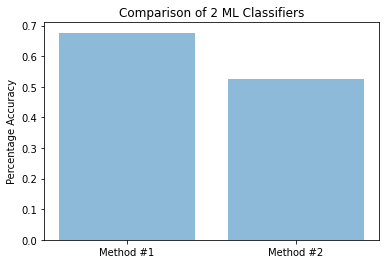

In [0]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import ExtraTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#method 2
class SentimentClassifier1:
    def train(self, trainX, trainY):
        self.clf = DummyClassifier(strategy='most_frequent')
        self.clf.fit(trainX, trainY)

    def classify(self, testX):
        # same as return ['EOS' for i in range(len(testX))]
        return self.clf.predict(testX)

class SentimentClassifier2:
    def train(self, trainX, trainY):
        self.clf = RandomForestClassifier()
        self.clf.fit(trainX, trainY)

    def classify(self, testX):
        return self.clf.predict(testX)

class SentimentClassifier3:
    def train(self, trainX, trainY):
        self.clf = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3)
        self.clf.fit(trainX, trainY)

    def classify(self, testX):
        return self.clf.predict(testX)

def load_data(file):
    with open(file) as fin:
        X = []
        y = []
        for line in fin:
            #print(line)
            arr = line.strip().split('\t', 1)
            X.append(arr[1])
            y.append(arr[0])
        return X, y

def get_sentiments(file):
    sentiments = {}
    arr = []
    with open(file) as fin:
         for line in fin:
             arr.append(line.split())
    for line in arr:
        word = line[2][6:]
        senti = line[5][14:]
        sentiments[word] = senti

    return sentiments

def addFeatures(xFile):
    newFeatures = []
    dataset = get_sentiments("/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/sentiments.txt")
    for i in range(len(xFile)):
        newFeatures.append([0,0,0])
        tweet = xFile[i]
        for word in tweet:
            if word.find('!') != -1:
                newFeatures[i][0] = 1
            if ':)' in word or ';)' in word:
                newFeatures[i][1] = 1
            elif ':(' in word or ';(' in word:
                newFeatures[i][1] = -1
            if word in dataset:
                if dataset[word] == 'positive':
                    newFeatures[i][2] = newFeatures[i][2] + 1
                else:
                    newFeatures[i][2] = newFeatures[i][2] - 1

    return newFeatures

def evaluate(outputs, golds):
    correct = 0
    for h, y in zip(outputs, golds):
        if h == y:
            correct += 1
    print(f'{correct} / {len(golds)}  {correct / len(golds)}')
    result = correct / len(golds)
    return result
    #print(f'{correct / len(golds)}')

#method 1
with open("/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/Twitter2016_raw.txt") as fin:
    tweets = []
    senses = []
    sentiments = []
    for line in fin:
        arr = line.lower().strip().split()
        tweets.append(line)
        sentiments.append(arr[0])
    for i, tweet in enumerate(tweets):
        if sentiments[i] == "positive":
            senses.append('positive')
        elif sentiments[i] == "negative":
            senses.append('negative')
        else:
            senses.append('neutral')
def get_results(X, y, testX, testY):
    dummy = SentimentClassifier1()
    dummy.train(X, y)
    outputsDummy = dummy.classify(testX)

    newFeatures = addFeatures(X)
    newTestFeatures = addFeatures(testX)
    randomForest = SentimentClassifier2()
    decisionTree = SentimentClassifier3()

    randomForest.train(newFeatures, y)
    outputsRF = randomForest.classify(newTestFeatures)

    decisionTree.train(newFeatures, y)
    outputsDecision = decisionTree.classify(newTestFeatures)

    outputs = []
    for i in range(len(outputsDummy)):
        final = []
        final.append(outputsDummy[i])
        final.append(outputsRF[i])
        final.append(outputsDecision[i])
        outputs.append(max(set(final), key=final.count))
    return evaluate(outputs, testY)

def features():
    vector = TfidfVectorizer()
    vector.fit(tweets)
    feats = (vector.transform(tweets))
    trainX, testX, trainY, testY = train_test_split(feats, senses, train_size = 0.5, test_size = 0.5)
    return trainX, testX, trainY, testY

def classifier(trainX, testX, trainY, testY):
    model = ExtraTreeClassifier()
    model = model.fit(trainX, trainY)
    prediction = model.predict(testX)
    return prediction

def main():

    # for method 1
    trainX, testX, trainY, testY = features()
    prediction = classifier(trainX, testX, trainY, testY)
    accuracy = accuracy_score(testY, prediction)
    print("Method #1:")
    print(accuracy)

    # for method 2
    
    print("Method #2:")
    X, y = load_data("/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/semeval_train.txt")

    testX1, testY1 = load_data('/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/Twitter2013_raw.txt')
    testX2, testY2 = load_data('/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/Twitter2014_raw.txt')
    testX3, testY3 = load_data('/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/Twitter2015_raw.txt')
    testX4, testY4 = load_data('/content/drive/My Drive/Information Retrieval Project/twitter_sentiment/Twitter2016_raw.txt')

    print("2013:")
    percent1 = get_results(X, y, testX1, testY1)
    print("2014:")
    percent2 = get_results(X, y, testX2, testY2)
    print("2015:")
    percent3 = get_results(X, y, testX3, testY3)
    print("2016:")
    percent4 = get_results(X, y, testX4, testY4)

    avg = (percent1 + percent2 + percent3 + percent4) / 4
    print("avg: ", avg)


    # graph comparison
    objects = ('Method #1', 'Method #2')
    y_pos = np.arange(len(objects))
    performance = [accuracy, avg]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Percentage Accuracy')
    plt.title('Comparison of 2 ML Classifiers')

    
if __name__ == '__main__':
    main()